In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statistics import mode
import re
from sklearn import metrics
from sklearn.metrics import auc, f1_score, plot_roc_curve, precision_score, recall_score
from sklearn.inspection import permutation_importance

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import time

In [3]:
df = pd.read_csv(r"C:\Users\Akalbir\PycharmProjects\Visa Prediction\h1b_kaggle.csv")

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

df = reduce_mem_usage(df)
df.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.00000,2016.0,"ANN ARBOR, MICHIGAN",-83.7500,42.28125
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.00000,2016.0,"PLANO, TEXAS",-96.6875,33.03125
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.00000,2016.0,"JERSEY CITY, NEW JERSEY",-74.0625,40.71875
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.00000,2016.0,"DENVER, COLORADO",-105.0000,39.75000
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.40625,2016.0,"ST. LOUIS, MISSOURI",-90.1875,38.62500


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int32  
 1   CASE_STATUS         object 
 2   EMPLOYER_NAME       object 
 3   SOC_NAME            object 
 4   JOB_TITLE           object 
 5   FULL_TIME_POSITION  object 
 6   PREVAILING_WAGE     float32
 7   YEAR                float16
 8   WORKSITE            object 
 9   lon                 float16
 10  lat                 float16
dtypes: float16(3), float32(1), int32(1), object(6)
memory usage: 177.5+ MB


,Unnamed: 0,PREVAILING_WAGE,YEAR,lon,lat
count,3.002458e+06,3.002373e+06,3002445.0,2.895216e+06,2.895216e+06
mean,1.501230e+06,1.472152e+05,NaN,NaN,NaN
std,8.667351e+05,5.286995e+06,NaN,0.000000e+00,0.000000e+00
min,1.000000e+00,0.000000e+00,2011.0,-1.578750e+02,1.343750e+01
25%,7.506152e+05,5.437100e+04,2012.0,-1.119375e+02,3.415625e+01
50%,1.501230e+06,6.502100e+04,2014.0,-8.618750e+01,3.909375e+01
75%,2.251844e+06,8.143200e+04,2015.0,-7.550000e+01,4.087500e+01
max,3.002458e+06,6.997607e+09,2016.0,1.457500e+02,6.481250e+01


In [5]:
df.CASE_STATUS.value_counts()

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64

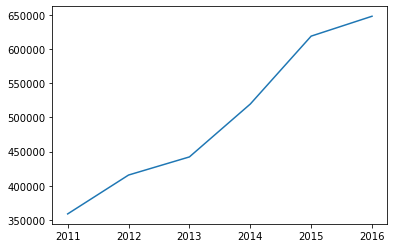

In [6]:
df.YEAR.value_counts().plot(kind = 'line')

In [7]:
import warnings
df.drop(['Unnamed: 0','lon','lat','YEAR'],axis=1,inplace=True)
warnings.filterwarnings("ignore")
df.CASE_STATUS[df['CASE_STATUS']=='REJECTED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='INVALIDATED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'
##Drop rows with withdrawn
df.EMPLOYER_NAME.describe()
df = df.drop(df[df.CASE_STATUS == 'WITHDRAWN'].index)
df['CASE_STATUS'] = df['CASE_STATUS'].map({'CERTIFIED' : 0,'DENIED' : 1})
df['FULL_TIME_POSITION'] = df['FULL_TIME_POSITION'].map({'N' : 0, 'Y' : 1})
df.head()


,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,WORKSITE
0,0.0,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,0.0,36067.0,"ANN ARBOR, MICHIGAN"
1,0.0,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,1.0,242674.0,"PLANO, TEXAS"
2,0.0,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,1.0,193066.0,"JERSEY CITY, NEW JERSEY"
3,0.0,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",1.0,220314.0,"DENVER, COLORADO"
5,0.0,BURGER KING CORPORATION,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",1.0,225000.0,"MIAMI, FLORIDA"


In [8]:
##check count of NAN
count_nan = len(df) - df.count()
print(count_nan)

CASE_STATUS              13
EMPLOYER_NAME            31
SOC_NAME              17086
JOB_TITLE                23
FULL_TIME_POSITION       14
PREVAILING_WAGE          66
WORKSITE                  0
dtype: int64


In [9]:
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].fillna(df['EMPLOYER_NAME'].mode()[0])
assert pd.notnull(df['EMPLOYER_NAME']).all().all()


In [10]:
print(np.nanpercentile(df.PREVAILING_WAGE,98))
df.PREVAILING_WAGE.median()

138611.0


65000.0

In [11]:
## replacing min and max with 2 and 98 percentile
df.loc[df.PREVAILING_WAGE < 34029, 'PREVAILING_WAGE']= 34029
df.loc[df['PREVAILING_WAGE'] > 138611, 'PREVAILING_WAGE']= 138611
df.PREVAILING_WAGE.fillna(df.PREVAILING_WAGE.mean(), inplace = True)
## Filling na in JOB_TITLE and FULL_TIME_POSITION with mode
df['JOB_TITLE'] = df['JOB_TITLE'].fillna(df['JOB_TITLE'].mode()[0])
df['FULL_TIME_POSITION'] = df['FULL_TIME_POSITION'].fillna(df['FULL_TIME_POSITION'].mode()[0])
df['SOC_NAME'] = df['SOC_NAME'].fillna(df['SOC_NAME'].mode()[0])

In [12]:
## Storing non null in df w.r.t. case status
df = df[df['CASE_STATUS'].notnull()]
print(df['CASE_STATUS'].value_counts())

0.0    2818282
1.0      94364
Name: CASE_STATUS, dtype: int64


Text(0, 0.5, 'Frequency')

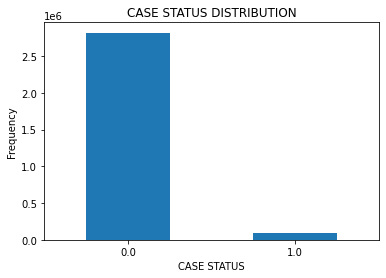

In [13]:
count_classes = pd.value_counts(df['CASE_STATUS'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("CASE STATUS DISTRIBUTION")

plt.xticks(range(2))

plt.xlabel("CASE STATUS")

plt.ylabel("Frequency")

In [14]:
df['NEW_EMPLOYER'] = np.nan
df.shape


(2912646, 8)

In [15]:
warnings.filterwarnings("ignore")

df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.lower()
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('university')] = 'university'
df['NEW_EMPLOYER']= df.NEW_EMPLOYER.replace(np.nan, 'non university', regex=True)

df.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,WORKSITE,NEW_EMPLOYER
0,0.0,university of michigan,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,0.0,36067.0,"ANN ARBOR, MICHIGAN",university
1,0.0,"goodman networks, inc.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,1.0,138611.0,"PLANO, TEXAS",non university
2,0.0,"ports america group, inc.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,1.0,138611.0,"JERSEY CITY, NEW JERSEY",non university
3,0.0,"gates corporation, a wholly-owned subsidiary o...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",1.0,138611.0,"DENVER, COLORADO",non university
5,0.0,burger king corporation,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",1.0,138611.0,"MIAMI, FLORIDA",non university


In [16]:
df['NEW_EMPLOYER'] = df['NEW_EMPLOYER'].map({'university' : 0, 'non university' : 1})
df.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,WORKSITE,NEW_EMPLOYER
0,0.0,university of michigan,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,0.0,36067.0,"ANN ARBOR, MICHIGAN",0
1,0.0,"goodman networks, inc.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,1.0,138611.0,"PLANO, TEXAS",1
2,0.0,"ports america group, inc.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,1.0,138611.0,"JERSEY CITY, NEW JERSEY",1
3,0.0,"gates corporation, a wholly-owned subsidiary o...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",1.0,138611.0,"DENVER, COLORADO",1
5,0.0,burger king corporation,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",1.0,138611.0,"MIAMI, FLORIDA",1


In [17]:
df['OCCUPATION'] = np.nan
df['SOC_NAME'] = df['SOC_NAME'].str.lower()
df.OCCUPATION[df['SOC_NAME'].str.contains('computer','programmer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('software','web developer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('database')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('math','statistic')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('predictive model','stats')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('teacher','linguist')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('professor','Teach')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('school principal')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('medical','doctor')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('physician','dentist')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('Health','Physical Therapists')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('surgeon','nurse')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('psychiatr')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('chemist','physicist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biology','scientist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biologi','clinical research')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('public relation','manage')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('management','operation')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('chief','plan')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('executive')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('advertis','marketing')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('promotion','market research')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business','business analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business systems analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('accountant','finance')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('financial')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('engineer','architect')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('surveyor','carto')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('technician','drafter')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('information security','information tech')] = 'Architecture & Engineering'
df['OCCUPATION']= df.OCCUPATION.replace(np.nan, 'Others', regex=True)

In [18]:
df.drop(['SOC_NAME','EMPLOYER_NAME'],axis=1,inplace=True)


In [19]:
def state_extractor(work_site):
    return work_site.split(', ')[1]

# State extractor
df['STATE'] = df['WORKSITE'].apply(state_extractor)
df = df.drop(['WORKSITE'],axis=1)
df.head()


,CASE_STATUS,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,NEW_EMPLOYER,OCCUPATION,STATE
0,0.0,POSTDOCTORAL RESEARCH FELLOW,0.0,36067.0,0,Advance Sciences,MICHIGAN
1,0.0,CHIEF OPERATING OFFICER,1.0,138611.0,1,Management Occupation,TEXAS
2,0.0,CHIEF PROCESS OFFICER,1.0,138611.0,1,Management Occupation,NEW JERSEY
3,0.0,"REGIONAL PRESIDEN, AMERICAS",1.0,138611.0,1,Management Occupation,COLORADO
5,0.0,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",1.0,138611.0,1,Management Occupation,FLORIDA


In [20]:
df_1 = df.loc[:,['NEW_EMPLOYER', 'CASE_STATUS']]
df_1s = df.loc[:,['OCCUPATION', 'CASE_STATUS']]
df_1j = df.loc[:,['JOB_TITLE', 'CASE_STATUS']]
df_1st = df.loc[:,['STATE', 'CASE_STATUS']]
df_1wg = df.loc[:,['PREVAILING_WAGE', 'CASE_STATUS']]


df_2_C = df_1[df_1.CASE_STATUS == 0].NEW_EMPLOYER
df_2_Cs = df_1s[df_1s.CASE_STATUS == 0].OCCUPATION
df_2_Cj = df_1j[df_1j.CASE_STATUS == 0].JOB_TITLE
df_2_Cst = df_1st[df_1st.CASE_STATUS == 0].STATE
df_2_Cwg = df_1wg[df_1wg.CASE_STATUS == 0].PREVAILING_WAGE

positive_counts = df_2_C.value_counts()
positive_counts_s = df_2_Cs.value_counts()
positive_counts_j = df_2_Cj.value_counts()
positive_counts_st = df_2_Cst.value_counts()
positive_counts_wg = df_2_Cwg.value_counts()

total_counts = df_1.NEW_EMPLOYER.value_counts()
total_counts_s = df_1s.OCCUPATION.value_counts()
total_counts_j = df_1j.JOB_TITLE.value_counts()
total_counts_st = df_1st.STATE.value_counts()
total_counts_wg = df_1wg.PREVAILING_WAGE.value_counts()

final_ratio_series = positive_counts / total_counts
final_ratio_series_s = positive_counts_s / total_counts_s
final_ratio_series_j = positive_counts_j / total_counts_j
final_ratio_series_st = positive_counts_st / total_counts_st
final_ratio_series_wg = positive_counts_wg / total_counts_wg


final_ratio_series.fillna(0, inplace=True)
final_ratio_series_s.fillna(0, inplace=True)
final_ratio_series_j.fillna(0, inplace=True)
final_ratio_series_st.fillna(0, inplace=True)
final_ratio_series_wg.fillna(0, inplace=True)

df['EMPLOYER_ACCEPTANCE'] = df.NEW_EMPLOYER.map(final_ratio_series)
df['SOC_ACCEPTANCE'] = df.OCCUPATION.map(final_ratio_series_s)
df['JOB_ACCEPTANCE'] = df.JOB_TITLE.map(final_ratio_series_j)
df['STATE_ACCEPTANCE'] = df.STATE.map(final_ratio_series_st)
df['WAGE_ACCEPTANCE'] = df.PREVAILING_WAGE.map(final_ratio_series_wg)

df['EMPLOYER_ACCEPTANCE'] = df['EMPLOYER_ACCEPTANCE'].round(decimals=3)
df['SOC_ACCEPTANCE'] = df['SOC_ACCEPTANCE'].round(decimals=3)
df['JOB_ACCEPTANCE'] = df['JOB_ACCEPTANCE'].round(decimals=3)
df['STATE_ACCEPTANCE'] = df['STATE_ACCEPTANCE'].round(decimals=3)
df['WAGE_ACCEPTANCE'] = df['WAGE_ACCEPTANCE'].round(decimals=3)


df = df.drop(['NEW_EMPLOYER','OCCUPATION','JOB_TITLE','STATE','PREVAILING_WAGE'], axis = 1)
# encoding wage
# df = pd.get_dummies(df, columns=['WAGE_CATEGORY'], drop_first=True)
print(df.columns)


Index(['CASE_STATUS', 'FULL_TIME_POSITION', 'EMPLOYER_ACCEPTANCE',
       'SOC_ACCEPTANCE', 'JOB_ACCEPTANCE', 'STATE_ACCEPTANCE',
       'WAGE_ACCEPTANCE'],
      dtype='object')


In [21]:
df.head(30)

,CASE_STATUS,FULL_TIME_POSITION,EMPLOYER_ACCEPTANCE,SOC_ACCEPTANCE,JOB_ACCEPTANCE,STATE_ACCEPTANCE,WAGE_ACCEPTANCE
0,0.0,0.0,0.972,0.971,0.981,0.972,0.979
1,0.0,1.0,0.967,0.955,0.886,0.970,0.908
2,0.0,1.0,0.967,0.955,1.000,0.976,0.908
3,0.0,1.0,0.967,0.955,1.000,0.963,0.908
5,0.0,1.0,0.967,0.955,1.000,0.946,0.908
6,0.0,1.0,0.967,0.955,0.886,0.970,0.983
7,0.0,1.0,0.967,0.955,0.876,0.967,0.908
8,0.0,1.0,0.967,0.955,0.829,0.970,1.000
10,0.0,1.0,0.967,0.955,1.000,0.974,0.908
11,0.0,1.0,0.967,0.955,1.000,0.972,0.908


In [22]:
count_nan = len(df) - df.count()
print(count_nan)

CASE_STATUS            0
FULL_TIME_POSITION     0
EMPLOYER_ACCEPTANCE    0
SOC_ACCEPTANCE         0
JOB_ACCEPTANCE         0
STATE_ACCEPTANCE       0
WAGE_ACCEPTANCE        0
dtype: int64


In [23]:
from imblearn.over_sampling import SMOTE
from collections import Counter
over_sampler = SMOTE(sampling_strategy="minority")
X = df.drop(['CASE_STATUS'],axis=1)
Y = df.CASE_STATUS

X_oversampled, Y_oversampled = over_sampler.fit_resample(X, Y)
counter = 0
o_df = pd.DataFrame()
for i in list(df.columns)[1:8]:
    o_df[i] = X_oversampled[i]
    counter += 1
    
o_df["CASE_STATUS"] = Y_oversampled
df = o_df.copy()
Counter(Y_oversampled)

Counter({0.0: 2818282, 1.0: 2818282})

In [24]:
df = df[['FULL_TIME_POSITION','EMPLOYER_ACCEPTANCE','SOC_ACCEPTANCE','JOB_ACCEPTANCE','STATE_ACCEPTANCE','WAGE_ACCEPTANCE','CASE_STATUS']]

In [25]:
df.head()
df.shape

(5636564, 7)

In [26]:
X = df.iloc[:,:6].values

Y = df.iloc[:,6].values

def classification_evaluation(classifier, X, Y, classifier_name, columns):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    accuracy_arr = np.zeros(shape=(1,10))
    f1_score_arr = np.zeros(shape=(1,10))
    precision_arr = np.zeros(shape=(1,10))
    recall_arr = np.zeros(shape=(1,10))
    feature_importance_arr = np.zeros(shape=(1,6))
    time_arr = []
    

    cv = StratifiedKFold(n_splits=10)
    fig, ax = plt.subplots(figsize=(15, 10))
    start_time = time.time()
    for i, (train, test) in enumerate(cv.split(X, Y)):
        itr_start_time = time.time()
        classifier.fit(X[train], Y[train])
        itr_end_time = time.time()
        viz = plot_roc_curve(classifier, X[test], Y[test],
                             name=f'ROC fold {i}',
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        try:
            feature_importance_arr += classifier.feature_importances_
        except:
            try:
                feature_importance_arr += np.array([abs(i) for i in classifier.coef_[0]])
            except:
                feature_importance_arr += np.array([abs(i) for i in permutation_importance(classifier, X[test], Y[test]).importances_mean])
            
        
        predict = classifier.predict(X[test])
        accuracy = classifier.score(X[test], Y[test])
        accuracy_arr[0, i] = accuracy
        f1 = f1_score(predict, Y[test])
        f1_score_arr[0, i] = f1
        precision = precision_score(predict, Y[test])
        precision_arr[0, i] = precision
        recall = recall_score(predict, Y[test])
        recall_arr[0, i] = recall
        train, test = train, test
        time_arr.append(itr_end_time-itr_start_time)
        print(f"Fold-{i}:  accuracy: {accuracy}  f1-score: {f1}  precision: {precision}  recall: {recall}  time: {itr_end_time-itr_start_time}")
    end_time = time.time()
    
    print()
    print(f"Classification Report for {classifier_name}")
    print("Average Accuracy :", np.mean(accuracy_arr))
    print("Average F1-Score :", np.mean(f1_score_arr))
    print("Average Precision :", np.mean(precision_arr))
    print("Average Recall :", np.mean(recall_arr))
    print("Total Time :", end_time - start_time)
    
    fig = plt.figure(figsize=(15, 10))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"Receiver Operating Characteristic for {classifier_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    feature_importance_arr /= 10
    
    fig = plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    feature_imp = pd.Series(feature_importance_arr[0], index = columns[:6])
    feature_imp.nlargest(10).plot(kind = 'bar')
    plt.title(f"Feature Importance of {classifier_name}")
    
    
    plt.subplot(1,2,2)
    plt.plot(time_arr, 'go-', color="darkblue")
    plt.plot([max(time_arr) for i in range(10)], color='lightcoral', label='UL')
    plt.plot([min(time_arr) for i in range(10)], color='lightgreen', label='LL')
    plt.title("Training time for every iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Time in sec.")
    plt.legend(loc="upper right")
    
    plt.show()
    
    return np.mean(accuracy_arr), np.mean(f1_score_arr), np.mean(precision_arr), np.mean(recall_arr), mean_auc

Fold-0:  accuracy: 0.7894819012271648  f1-score: 0.7570453968435967  precision: 0.6559745660473764  recall: 0.8949345519324607  time: 39.54771375656128
Fold-1:  accuracy: 0.8079647729026695  f1-score: 0.7733474604663629  precision: 0.6552329789800871  recall: 0.943409625012772  time: 31.24905776977539
Fold-2:  accuracy: 0.7702113164566394  f1-score: 0.7430159838732718  precision: 0.6643851413445742  recall: 0.8427574163174737  time: 30.332176446914673
Fold-3:  accuracy: 0.7783244065096326  f1-score: 0.7497110486580039  precision: 0.664001930248484  recall: 0.8608261649569897  time: 42.9041051864624
Fold-4:  accuracy: 0.7817126048511859  f1-score: 0.7528687265123959  precision: 0.6649978000766424  recall: 0.8674973731837938  time: 35.681159257888794
Fold-5:  accuracy: 0.7740962572916814  f1-score: 0.7465454849458385  precision: 0.665395205586386  recall: 0.8502389394172961  time: 37.61005997657776
Fold-6:  accuracy: 0.7691411073420668  f1-score: 0.7428080127286563  precision: 0.66675419

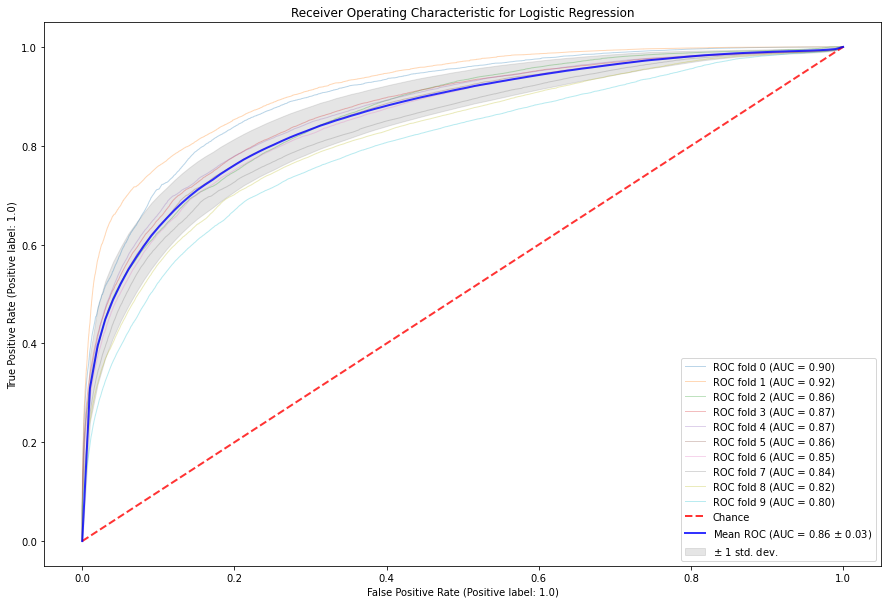

<Figure size 1080x720 with 0 Axes>

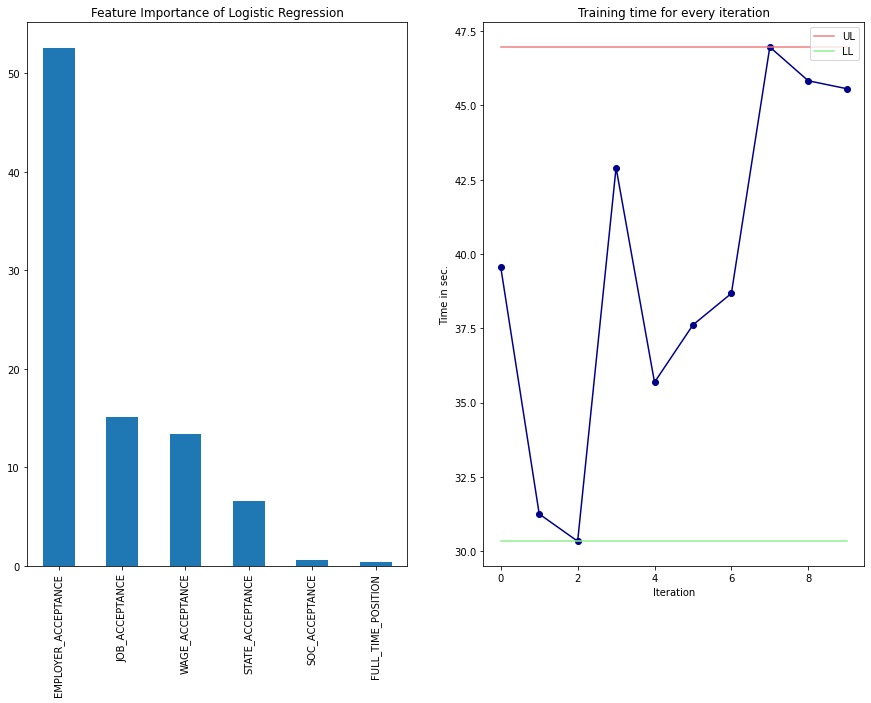

In [27]:
classifier = LogisticRegression()
lr_acc, lr_f1, lr_precision, lr_recall, lr_auc = classification_evaluation(classifier, X, Y, "Logistic Regression", list(df.columns))

Fold-0:  accuracy: 0.850275965702546  f1-score: 0.827932676133873  precision: 0.7204252238954256  recall: 0.9731543302482302  time: 112.07783460617065
Fold-1:  accuracy: 0.927913607034065  f1-score: 0.9233451054966946  precision: 0.8683168457356969  recall: 0.9858199455356998  time: 110.92630195617676
Fold-2:  accuracy: 0.9158264689341212  f1-score: 0.912179058837902  precision: 0.8742925674788613  recall: 0.9534978213591933  time: 110.06328773498535
Fold-3:  accuracy: 0.9234552218813924  f1-score: 0.9197226155411955  precision: 0.876957303897044  recall: 0.9668727016665363  time: 113.214115858078
Fold-4:  accuracy: 0.9251280923116227  f1-score: 0.9213218789383805  precision: 0.8767510680273074  recall: 0.9706670333123821  time: 113.32862615585327
Fold-5:  accuracy: 0.9173893296620634  f1-score: 0.9135378833455885  precision: 0.8728444299359893  recall: 0.9582112807728265  time: 100.2034969329834
Fold-6:  accuracy: 0.9214254793703961  f1-score: 0.9179637357813255  precision: 0.87922775

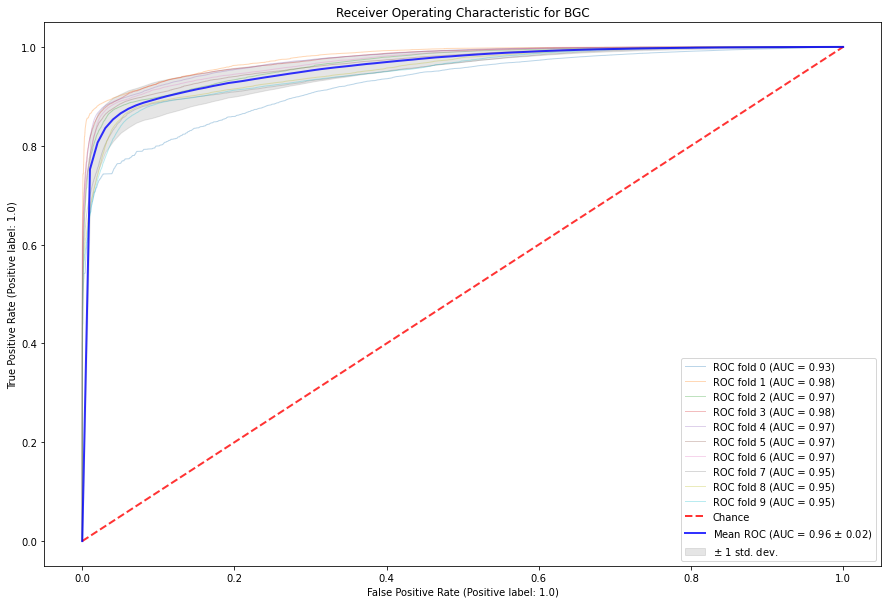

<Figure size 1080x720 with 0 Axes>

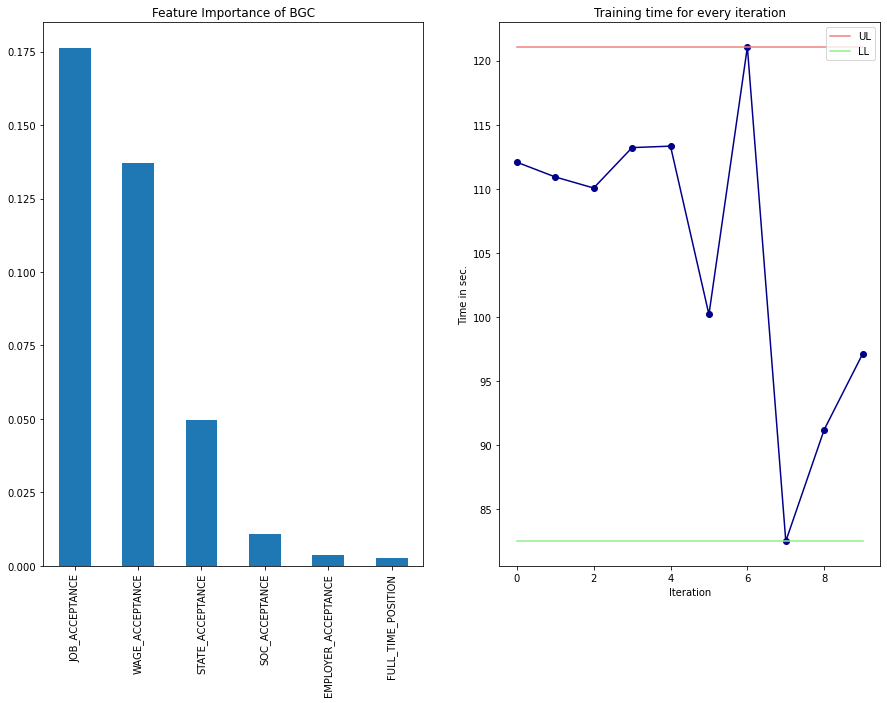

In [28]:
classifier = BaggingClassifier( max_samples=0.5, max_features=0.5, n_estimators = 15)
bgc_acc, bgc_f1, bgc_precision, bgc_recall, bgc_auc = classification_evaluation(classifier, X, Y, "BGC", list(df.columns))

Fold-0:  accuracy: 0.7853535039926764  f1-score: 0.7489557720439478  precision: 0.6403693032629831  recall: 0.9018874901927468  time: 9.614321231842041
Fold-1:  accuracy: 0.8061711288957646  f1-score: 0.7698003164763665  precision: 0.6481754829186596  recall: 0.9476119581061663  time: 8.700946569442749
Fold-2:  accuracy: 0.7675820578827195  f1-score: 0.7407709355706823  precision: 0.6641545050367421  recall: 0.8373693134285625  time: 8.536237239837646
Fold-3:  accuracy: 0.7763923804725215  f1-score: 0.7466206164510241  precision: 0.6588924489672816  recall: 0.8612980579687289  time: 8.449297666549683
Fold-4:  accuracy: 0.778982216103439  f1-score: 0.7482458976638914  precision: 0.6568935662886584  recall: 0.8691106604322761  time: 8.400512456893921
Fold-5:  accuracy: 0.7719229459102716  f1-score: 0.7432069912609237  precision: 0.6600976482109655  recall: 0.8502584587540049  time: 8.5267653465271
Fold-6:  accuracy: 0.7676437401535688  f1-score: 0.7414229840532756  precision: 0.666239692

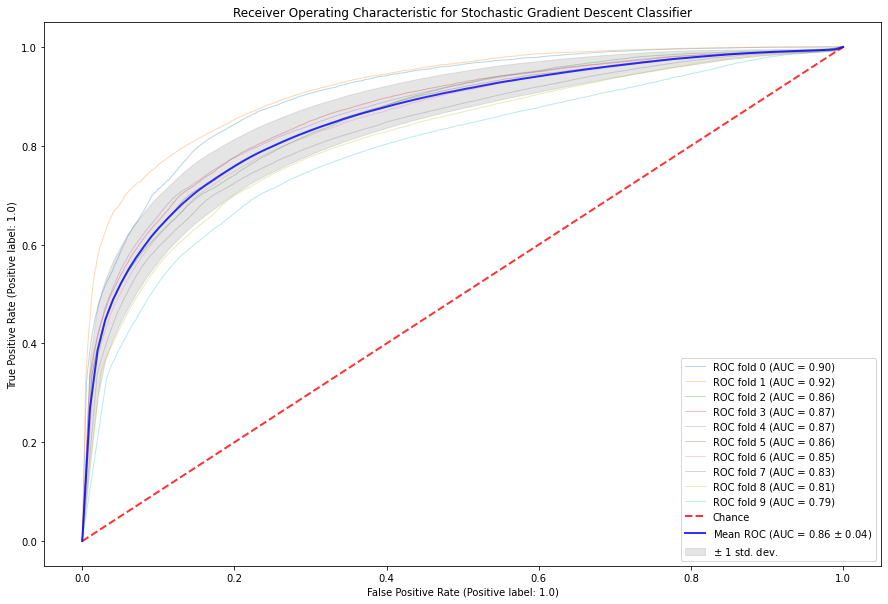

<Figure size 1080x720 with 0 Axes>

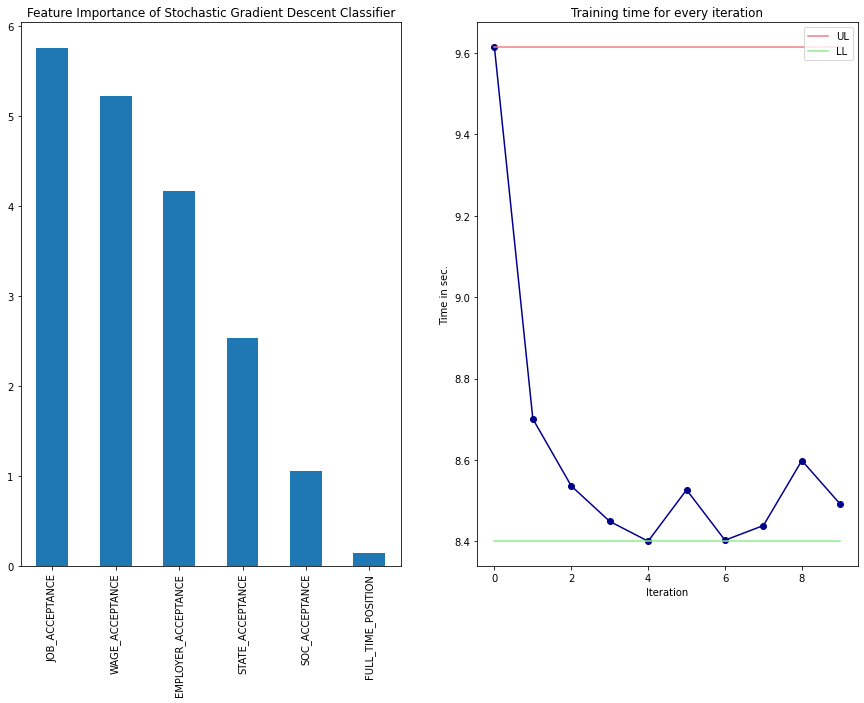

In [29]:
classifier = SGDClassifier(loss="modified_huber", penalty = "l2")
sgd_acc, sgd_f1, sgd_precision, sgd_recall, sgd_auc = classification_evaluation(classifier, X, Y, "Stochastic Gradient Descent Classifier", list(df.columns))

Fold-0:  accuracy: 0.7286470317941585  f1-score: 0.6576308367282984  precision: 0.5212221638730006  recall: 0.8907477927622004  time: 1.2400259971618652
Fold-1:  accuracy: 0.7455899598514699  f1-score: 0.6699563624311833  precision: 0.5164284599117192  recall: 0.9533866107690292  time: 1.2271852493286133
Fold-2:  accuracy: 0.7239207532240352  f1-score: 0.6510536961211246  precision: 0.51509958166122  recall: 0.8845087585681645  time: 1.2864294052124023
Fold-3:  accuracy: 0.7315370872711596  f1-score: 0.6570279121950114  precision: 0.5142905804583631  recall: 0.9094342937456079  time: 1.299508810043335
Fold-4:  accuracy: 0.7314283889464496  f1-score: 0.6566367265469062  precision: 0.5136075904452361  recall: 0.9100734351029852  time: 1.316547155380249
Fold-5:  accuracy: 0.7280185077423109  f1-score: 0.6543361307400577  precision: 0.5148565791901444  recall: 0.8974690434072663  time: 1.2426233291625977
Fold-6:  accuracy: 0.7244791149211576  f1-score: 0.6526938206833007  precision: 0.5177

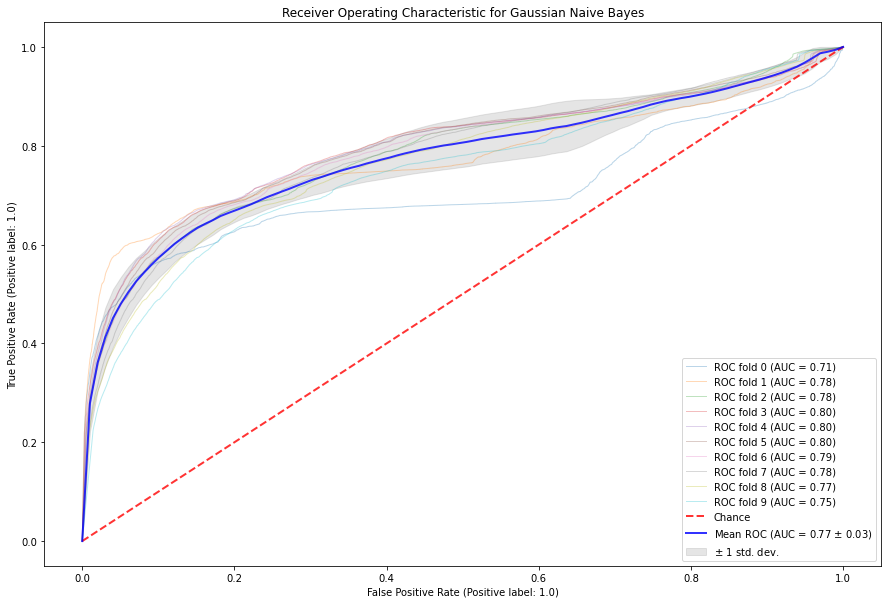

<Figure size 1080x720 with 0 Axes>

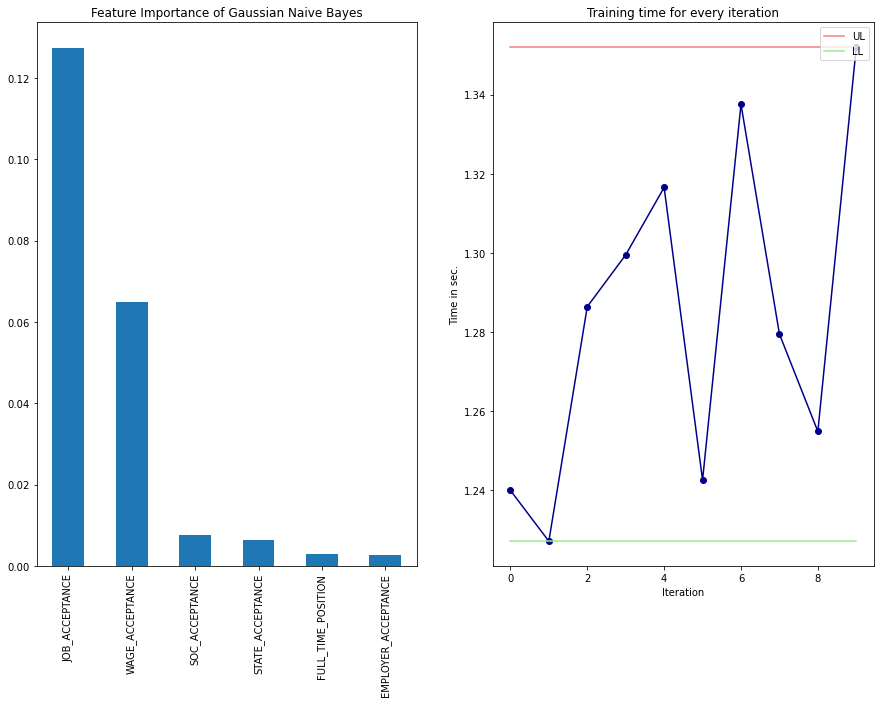

In [30]:
classifier = GaussianNB()
gn_acc, gn_f1, gn_precision, gn_recall, gn_auc = classification_evaluation(classifier, X, Y, "Gaussian Naive Bayes", list(df.columns))

Fold-0:  accuracy: 0.8246309368995683  f1-score: 0.8207768849177569  precision: 0.8031281490838383  recall: 0.8392187106055438  time: 217.2734522819519
Fold-1:  accuracy: 0.909091876797414  f1-score: 0.9078579918685006  precision: 0.8957023432732021  recall: 0.9203481101498099  time: 204.66214442253113
Fold-2:  accuracy: 0.9044631752998721  f1-score: 0.9036034584608775  precision: 0.8955430420574177  recall: 0.9118102897027106  time: 203.88346314430237
Fold-3:  accuracy: 0.9069806637724716  f1-score: 0.9057276168043656  precision: 0.8936873068420922  recall: 0.9180967864224893  time: 204.98040628433228
Fold-4:  accuracy: 0.9133496316902507  f1-score: 0.9118633729795669  precision: 0.8964865095022496  recall: 0.9277769413527319  time: 204.69223523139954
Fold-5:  accuracy: 0.9060260158678343  f1-score: 0.9051300926149807  precision: 0.8965823126162056  recall: 0.9138424259959133  time: 202.93282175064087
Fold-6:  accuracy: 0.9011773138226152  f1-score: 0.9007444787757618  precision: 0.89

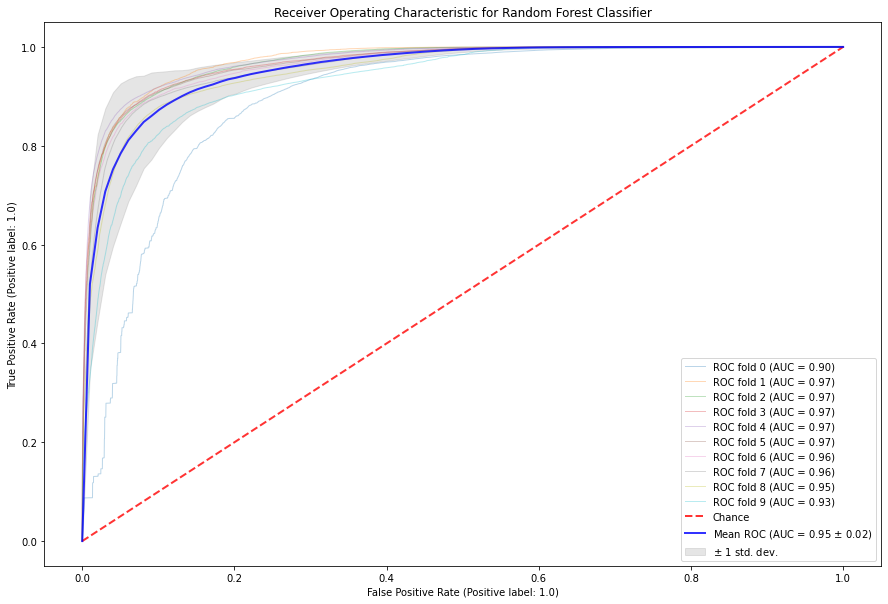

<Figure size 1080x720 with 0 Axes>

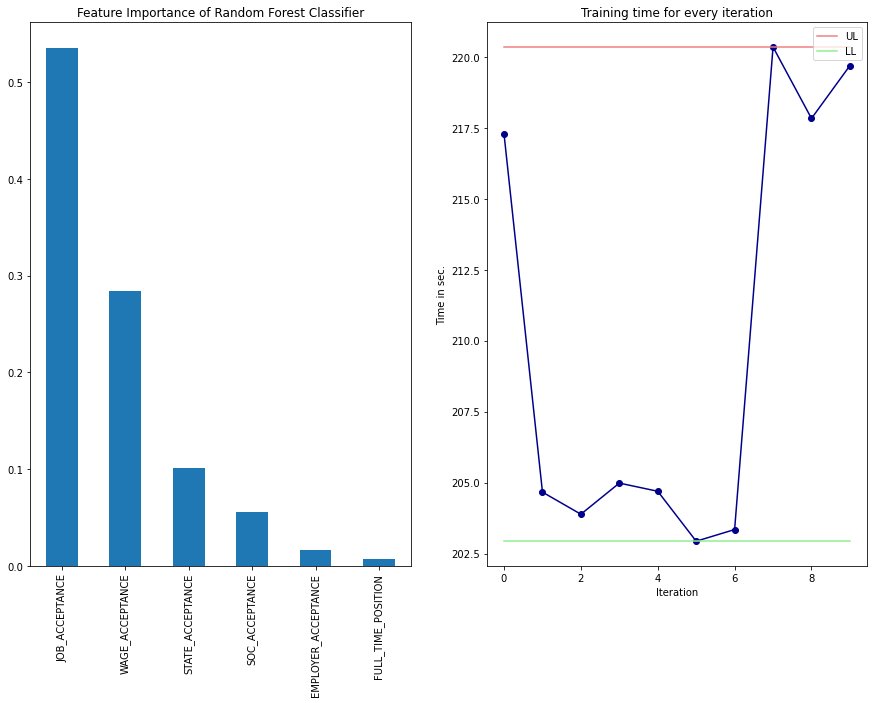

In [31]:
classifier = RandomForestClassifier(n_estimators=25, max_depth = 26)
rf_acc, rf_f1, rf_precision, rf_recall, rf_auc = classification_evaluation(classifier, X, Y, "Random Forest Classifier", list(df.columns))

Fold-0:  accuracy: 0.8177597368612471  f1-score: 0.8187405484668445  precision: 0.8231722894815278  recall: 0.8143562705569733  time: 772.53715467453
Fold-1:  accuracy: 0.8912281760006528  f1-score: 0.8905659299664789  precision: 0.8851781937919582  recall: 0.8960196539016874  time: 729.836630821228
Fold-2:  accuracy: 0.8964636294767917  f1-score: 0.8955193953054533  precision: 0.8874246440217295  recall: 0.9037631805271488  time: 706.6933181285858
Fold-3:  accuracy: 0.8966303975644763  f1-score: 0.8958845214333323  precision: 0.8894648882833207  recall: 0.9023974945102415  time: 712.2899994850159
Fold-4:  accuracy: 0.9018071305902892  f1-score: 0.9006168017884558  precision: 0.8898299672140454  recall: 0.9116683692202547  time: 681.4880208969116
Fold-5:  accuracy: 0.8917336105709865  f1-score: 0.8916384479749131  precision: 0.8908554153597229  recall: 0.8924228583209222  time: 643.4234988689423
Fold-6:  accuracy: 0.8864200860099067  f1-score: 0.8869571666189915  precision: 0.891171210

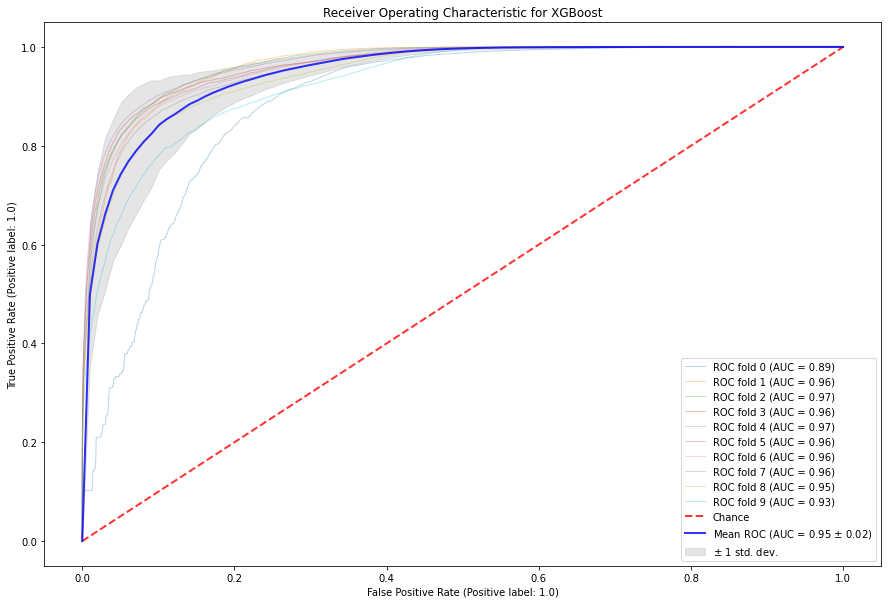

<Figure size 1080x720 with 0 Axes>

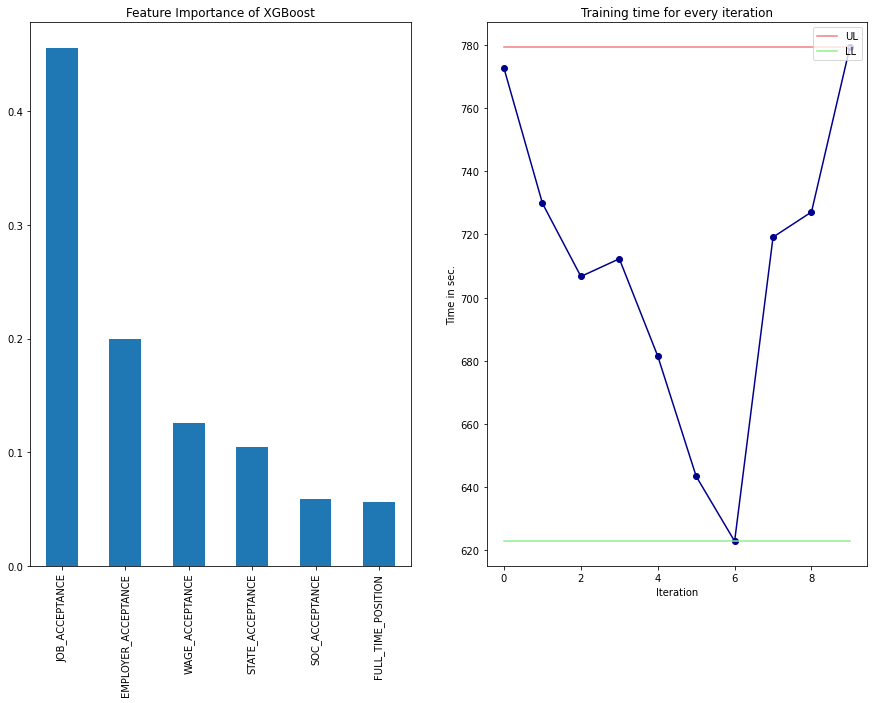

In [32]:
import warnings
warnings.filterwarnings("ignore")
classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=20,  min_child_weight=1, n_estimators=35, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=0.8, use_label_encoder=False, disable_default_eval_metric=1)
xg_acc, xg_f1, xg_precision, xg_recall, xg_auc = classification_evaluation(classifier, X, Y, "XGBoost", list(df.columns))


Fold-0:  accuracy: 0.8165320398753142  f1-score: 0.8000317124531323  precision: 0.7340186212867422  recall: 0.8790917860436259  time: 150.98108625411987
Fold-1:  accuracy: 0.8355400536141661  f1-score: 0.8240882187174431  precision: 0.7704415459074329  recall: 0.8857649866400147  time: 145.15301036834717
Fold-2:  accuracy: 0.7940201221664949  f1-score: 0.7854769867519078  precision: 0.7541949196143761  recall: 0.8194663448749138  time: 143.04915952682495
Fold-3:  accuracy: 0.8042195874441371  f1-score: 0.7940518337006768  precision: 0.7548477977780853  recall: 0.8375511811023622  time: 150.81672549247742
Fold-4:  accuracy: 0.8070347871751565  f1-score: 0.796672461817434  precision: 0.7560710788140285  recall: 0.841881929024662  time: 148.42504048347473
Fold-5:  accuracy: 0.8010825751877031  f1-score: 0.7958515184454846  precision: 0.775458790467945  recall: 0.8173457748190811  time: 153.66803741455078
Fold-6:  accuracy: 0.7930155981662574  f1-score: 0.7847866829980963  precision: 0.754

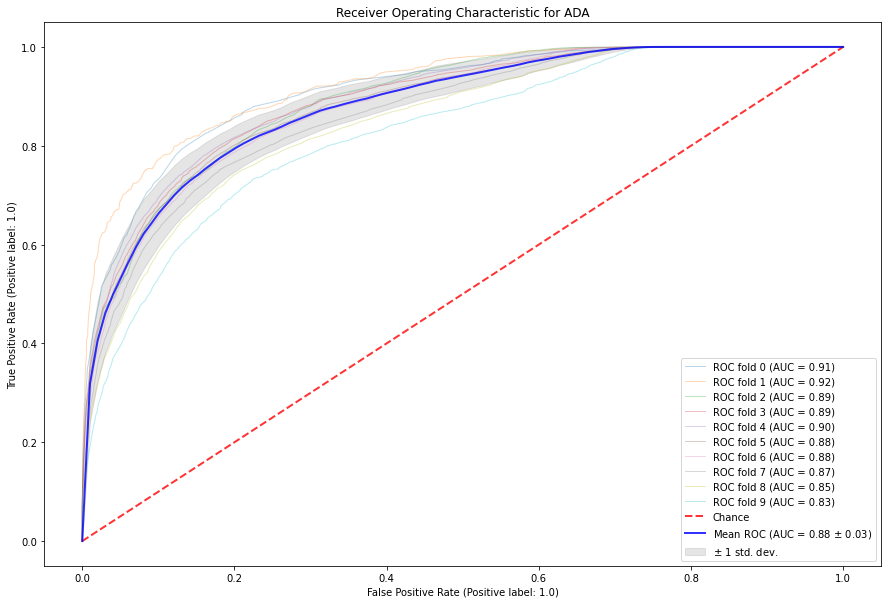

<Figure size 1080x720 with 0 Axes>

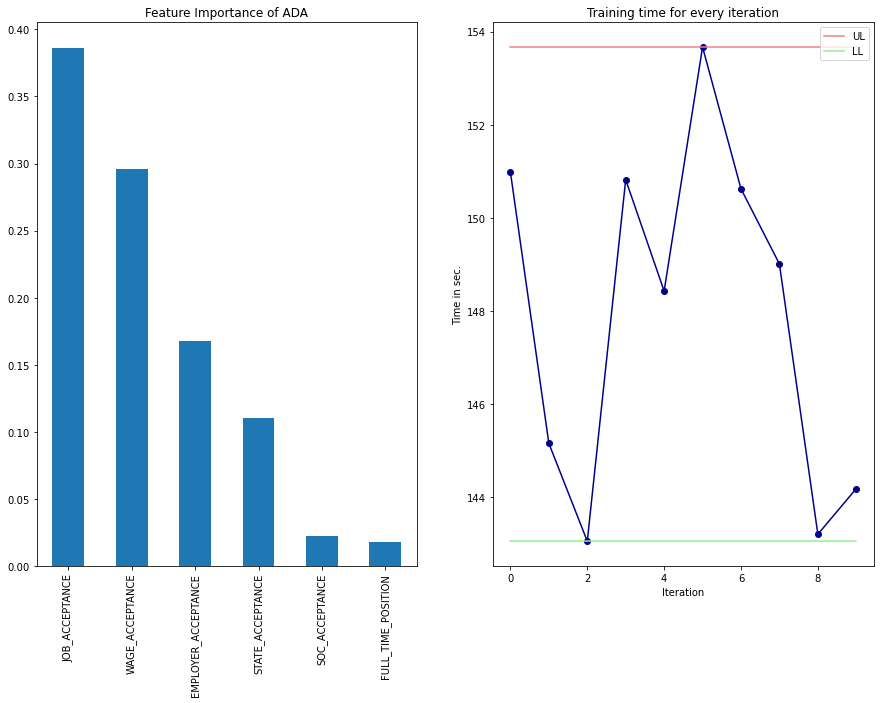

In [34]:
classifier = AdaBoostClassifier()
ada_acc, ada_f1, ada_precision, ada_recall, ada_auc = classification_evaluation(classifier, X, Y, "ADA", list(df.columns))

Fold-0:  accuracy: 0.831399237479531  f1-score: 0.8185510124201663  precision: 0.760591566487361  recall: 0.8860724959386898  time: 141.01083540916443
Fold-1:  accuracy: 0.8540974386905512  f1-score: 0.8456286896862417  precision: 0.7992392523099195  recall: 0.8977350173570287  time: 140.40179467201233
Fold-2:  accuracy: 0.8211997722018888  f1-score: 0.8160120051701099  precision: 0.7930021395952865  recall: 0.840397089514355  time: 141.84737253189087
Fold-3:  accuracy: 0.8241874047514712  f1-score: 0.8171900192221841  precision: 0.7859091860667284  recall: 0.8510641568012665  time: 137.28238034248352
Fold-4:  accuracy: 0.8316100600366181  f1-score: 0.8248450781160613  precision: 0.7929872120584186  recall: 0.8593698328834337  time: 139.98187160491943
Fold-5:  accuracy: 0.8265768482904466  f1-score: 0.8230088014876161  precision: 0.8064173893296621  recall: 0.8402972658199767  time: 140.10274696350098
Fold-6:  accuracy: 0.8155931986885618  f1-score: 0.8127184668939323  precision: 0.800

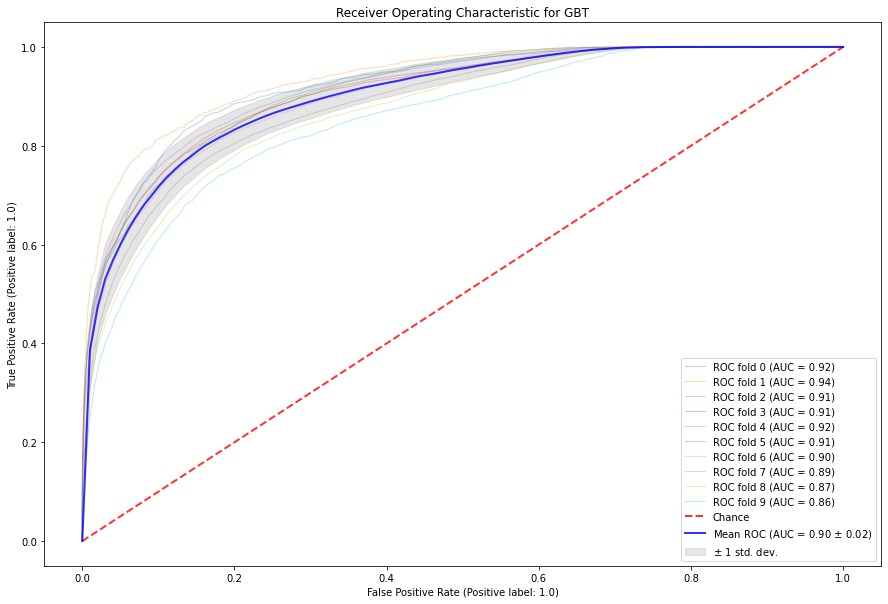

<Figure size 1080x720 with 0 Axes>

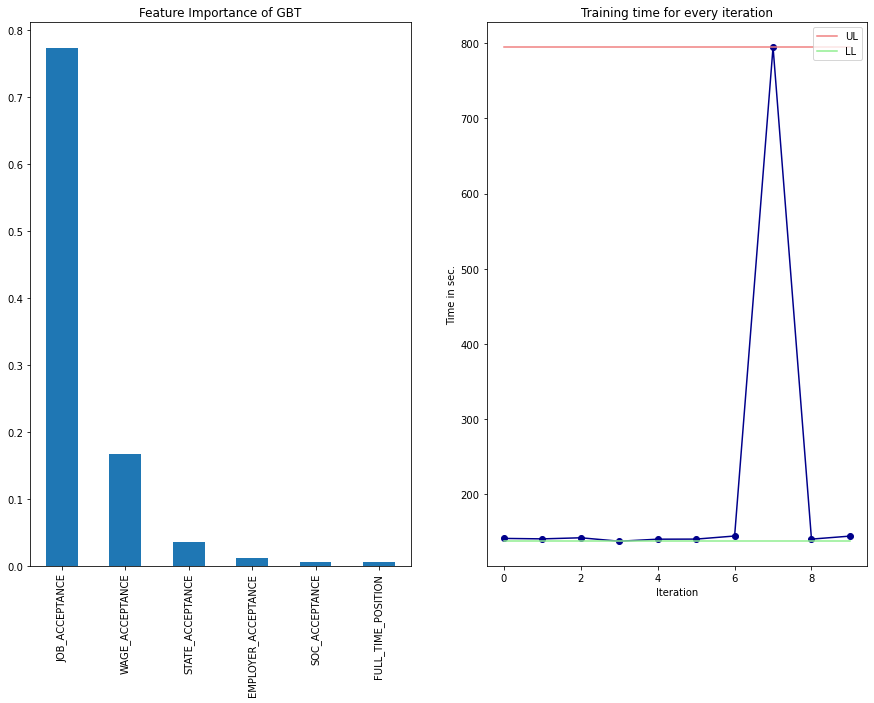

In [35]:
classifier = GradientBoostingClassifier(n_estimators = 25, learning_rate = 0.5)
gbt_acc, gbt_f1, gbt_precision, gbt_recall, gbt_auc = classification_evaluation(classifier, X, Y, "GBT", list(df.columns))

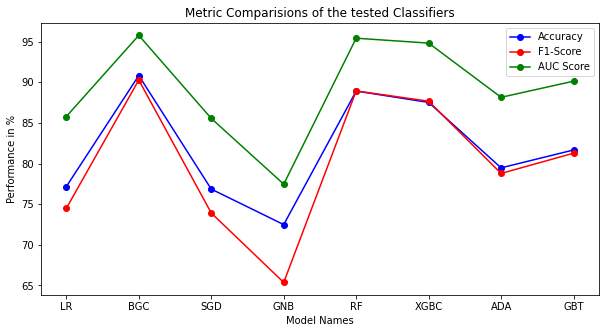

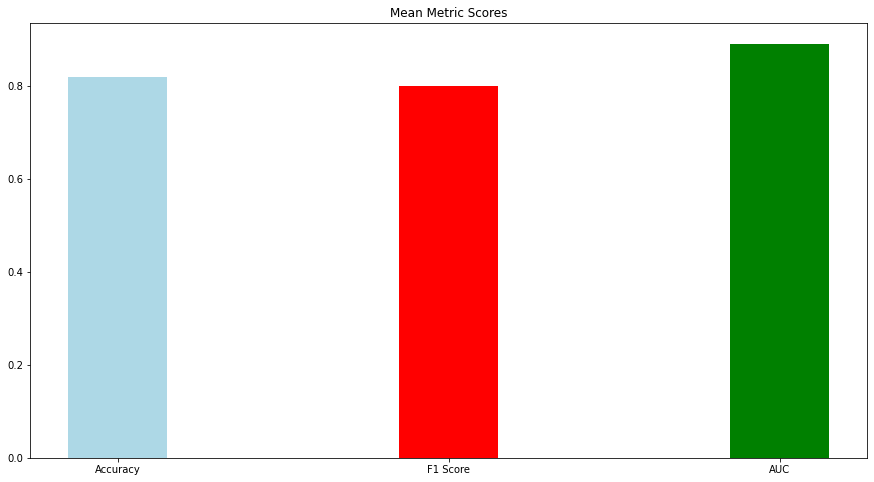

In [44]:
accuracy = [lr_acc,bgc_acc, sgd_acc, gn_acc, rf_acc, xg_acc,ada_acc, gbt_acc]
f1_scores = [lr_f1, bgc_f1, sgd_f1, gn_f1, rf_f1, xg_f1,ada_f1, gbt_f1]
auc_scores = [lr_auc, bgc_auc, sgd_auc, gn_auc, rf_auc, xg_auc,ada_auc, gbt_auc]

mean_acc = sum(accuracy)/8
mean_f1 = sum(f1_scores)/8
mean_auc = sum(auc_scores)/8

fig = plt.figure(figsize=(10,5))
plt.title("Metric Comparisions of the tested Classifiers")
plt.plot([i*100 for i in accuracy],'go-', color="blue", label="Accuracy")
plt.plot([i*100 for i in f1_scores],'go-', color="red", label="F1-Score")
plt.plot([i*100 for i in auc_scores],'go-', color="green", label="AUC Score")
plt.xticks([i for i in range(8)], ["LR","BGC", "SGD", "GNB", "RF", "XGBC","ADA", "GBT"])
plt.legend()
plt.xlabel('Model Names')
plt.ylabel('Performance in %')
plt.show()

fig = plt.figure(figsize=(15,8))
plt.title("Mean Metric Scores")
plt.bar(height=[mean_acc, mean_f1, mean_auc], x = ["Accuracy", "F1 Score", "AUC"], width=.3, color=["lightblue", "red", "green"])
plt.show()

In [51]:
def hybrid_model_formation(clf1,clf2, clf3, clf4, clf5, clf6,clf7, clf8, X, Y, columns):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
    
    print("Phase 1 Started")
    print("Training Models and Generating Report:")
    print("------------------------------------------------------------------------------------------------------")
    try:
        t1 = time.time()
        clf1.fit(x_train, y_train)
        clf1_acc = clf1.score(x_test, y_test)
        pred1 = clf1.predict(x_test)
        clf1_f1 = f1_score(pred1, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf1.predict_proba(x_test)[:, 1])
        clf1_auc = metrics.auc(fpr, tpr)
        feature_imp1 = pd.Series([abs(i) for i in clf1.coef_[0]], index = columns[:6])
        t1_ = time.time()
        final_t1 = t1_ - t1
        print("Model 1 Trained and Tested: ")
        print("Accuracy: ", clf1_acc)
        print("F1 Score:", clf1_f1)
        print("AUC Score: ", clf1_auc)
        print("Time :", final_t1)

        print("------------------------------------------------------------------------------------------------------")
        t2 = time.time()
        clf2.fit(x_train, y_train)
        clf2_acc = clf2.score(x_test, y_test)
        pred2 = clf2.predict(x_test)
        clf2_f1 = f1_score(pred2, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf2.predict_proba(x_test)[:, 1])
        clf2_auc = metrics.auc(fpr, tpr)
        feature_imp2 = pd.Series([abs(i) for i in permutation_importance(clf2, x_test, y_test).importances_mean], index = columns[:6])
        t2_ = time.time()
        final_t2 = t2_ - t2
        print("Model 2 Trained and Tested: ")
        print("Accuracy: ", clf2_acc)
        print("F1 Score:", clf2_f1)
        print("AUC Score: ", clf2_auc)
        print("Time :", final_t2)

        print("------------------------------------------------------------------------------------------------------")
        t3 = time.time()
        clf3.fit(x_train, y_train)
        clf3_acc = clf3.score(x_test, y_test)
        pred3 = clf3.predict(x_test)
        clf3_f1 = f1_score(pred3, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf3.predict_proba(x_test)[:, 1])
        clf3_auc = metrics.auc(fpr, tpr)
        feature_imp3 = pd.Series([abs(i) for i in permutation_importance(clf3, x_test, y_test).importances_mean], index = columns[:6])
        t3_ = time.time()
        final_t3 = t3_ - t3
        print("Model 3 Trained and Tested: ")
        print("Accuracy: ", clf3_acc)
        print("F1 Score:", clf3_f1)
        print("AUC Score: ", clf3_auc)
        print("Time :", final_t3)

        print("------------------------------------------------------------------------------------------------------")
        t4 = time.time()
        clf4.fit(x_train, y_train)
        clf4_acc = clf4.score(x_test, y_test)
        pred4 = clf4.predict(x_test)
        clf4_f1 = f1_score(pred4, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf4.predict_proba(x_test)[:, 1])
        clf4_auc = metrics.auc(fpr, tpr)
        feature_imp4 = pd.Series([abs(i) for i in permutation_importance(clf4, x_test, y_test).importances_mean], index = columns[:6])
        t4_ = time.time()
        final_t4 = t4_ - t4
        print("Model 4 Trained and Tested: ")
        print("Accuracy: ", clf4_acc)
        print("F1 Score:", clf4_f1)
        print("AUC Score: ", clf4_auc)
        print("Time :", final_t4)

        print("------------------------------------------------------------------------------------------------------")
        t5 = time.time()
        clf5.fit(x_train, y_train)
        clf5_acc = clf5.score(x_test, y_test)
        pred5 = clf5.predict(x_test)
        clf5_f1 = f1_score(pred5, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf5.predict_proba(x_test)[:, 1])
        clf5_auc = metrics.auc(fpr, tpr)
        feature_imp5 = pd.Series(clf5.feature_importances_, index = columns[:6])
        t5_ = time.time()
        final_t5 = t5_ - t5
        print("Model 5 Trained and Tested: ")
        print("Accuracy: ", clf5_acc)
        print("F1 Score:", clf5_f1)
        print("AUC Score: ", clf5_auc)
        print("Time :", final_t5)

        print("------------------------------------------------------------------------------------------------------")
        t6 = time.time()
        clf6.fit(x_train, y_train)
        clf6_acc = clf6.score(x_test, y_test)
        pred6 = clf6.predict(x_test)
        clf6_f1 = f1_score(pred6, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf6.predict_proba(x_test)[:, 1])
        clf6_auc = metrics.auc(fpr, tpr)
        feature_imp6 = pd.Series(clf6.feature_importances_, index = columns[:6])
        t6_ = time.time()
        final_t6 = t6_ - t6
        print("Model 6 Trained and Tested: ")
        print("Accuracy: ", clf6_acc)
        print("F1 Score:", clf6_f1)
        print("AUC Score: ", clf6_auc)
        print("Time :", final_t6)

        print("------------------------------------------------------------------------------------------------------")
        t7 = time.time()
        clf7.fit(x_train, y_train)
        clf7_acc = clf7.score(x_test, y_test)
        pred7 = clf7.predict(x_test)
        clf7_f1 = f1_score(pred7, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf7.predict_proba(x_test)[:, 1])
        clf7_auc = metrics.auc(fpr, tpr)
        feature_imp7 = pd.Series([abs(i) for i in permutation_importance(clf7, x_test, y_test).importances_mean], index = columns[:6])
        t7_ = time.time()
        final_t7 = t7_ - t7
        print("Model 7 Trained and Tested: ")
        print("Accuracy: ", clf7_acc)
        print("F1 Score:", clf7_f1)
        print("AUC Score: ", clf7_auc)
        print("Time :", final_t7)

        print("------------------------------------------------------------------------------------------------------")
        t8 = time.time()
        clf8.fit(x_train, y_train)
        clf8_acc = clf8.score(x_test, y_test)
        pred8 = clf8.predict(x_test)
        clf8_f1 = f1_score(pred8, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, clf8.predict_proba(x_test)[:, 1])
        clf8_auc = metrics.auc(fpr, tpr)
        feature_imp8 = pd.Series([abs(i) for i in permutation_importance(clf7, x_test, y_test).importances_mean], index = columns[:6])
        t8_ = time.time()
        final_t8 = t8_ - t8
        print("Model 8 Trained and Tested: ")
        print("Accuracy: ", clf8_acc)
        print("F1 Score:", clf8_f1)
        print("AUC Score: ", clf8_auc)
        print("Time :", final_t8)
        print("------------------------------------------------------------------------------------------------------")
        print("Process Successfully completed without any errors....")
    except:
        print("Error Occured during model training and evaluation....")
        return "Error!!"
    
    print()
    print("Phase 2 Started")
    print("The slelection process has started....")
    all_classifiers = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]
    all_classifiers_names = ["LR", "BGC", "SGD", "GNB", "RF","XGB","ADA", "GBT"]
    selected_classifiers = [0 for i in range(8)]
    classifiers = {"clf1":clf1, "clf2":clf2, "clf3":clf3, "clf4":clf4, "clf5":clf5, "clf6":clf6, "clf7":clf7, "clf8":clf8}
    accuracys = [clf1_acc, clf2_acc, clf3_acc, clf4_acc, clf5_acc, clf6_acc, clf7_acc, clf8_acc]
    f1_scores = [clf1_f1, clf2_f1, clf3_f1, clf4_f1, clf5_f1, clf6_f1, clf7_f1, clf8_f1]
    auc_scores = [clf1_auc, clf2_auc, clf3_auc, clf4_auc, clf5_auc, clf6_auc, clf7_auc, clf8_auc]
    train_time = [final_t1, final_t2, final_t3, final_t4, final_t5, final_t6, final_t7, final_t8]
    f_imp = [feature_imp1, feature_imp2, feature_imp3, feature_imp4, feature_imp5, feature_imp6, feature_imp7, feature_imp8]
    
    fig = plt.figure(figsize=(20, 12))
    for o in range(8):
        plt.subplot(4,2,o+1)
        f_imp[o].nlargest(10).plot(kind = 'barh')
        plt.title(f"Feature Importance of {all_classifiers_names[o]}")
    
    
    fig = plt.figure(figsize=(10, 5))
    plt.plot([i*100 for i in accuracys], 'go-', color='black', label='Accuracy')
    plt.plot([i*100 for i in f1_scores], 'go-', color='red', label='F1-Score')
    plt.plot([i*100 for i in auc_scores], 'go-', color='green', label='AUC-Score')
    plt.title('Model Performance')
    plt.legend()
    plt.xticks([i for i in range(8)], all_classifiers_names)
    plt.xlabel('Model Names')
    plt.ylabel('Performance in %')
    plt.show()
    
    plt.plot(train_time, 'go-', color='darkblue', label='Train Time(sec)')
    plt.legend()
    plt.xticks([i for i in range(8)], all_classifiers_names)
    plt.xlabel('Model Names')
    plt.ylabel('Time in Seconds ')
    plt.show()
    for i in range(8):
        if accuracys[i] >= .80 and f1_scores[i] >= .80 and auc_scores[i] >= .80:
            selected_classifiers[i] = 1
            
    for j in range(8):
        if not selected_classifiers[j]:
            all_classifiers[j] = None
            all_classifiers_names[j] = None
            accuracys[j] = None
            
    all_classifiers = [i for i in all_classifiers if i != None]
    all_classifiers_names = [i for i in all_classifiers_names if i != None]
    accuracys = [i for i in accuracys if i != None]
    
    print("The selected classifiers are: ")
    for i in range(len(all_classifiers)):
        print(f"{i+1}. {all_classifiers_names[i]}")
    
    print()
    print("Phase 3 Started")
    # Final testing with formula:
    numerator = []
    denominator = sum([i for i in accuracys])
    for i in range(len(all_classifiers)):
        proba = all_classifiers[i].predict_proba(x_test)[:, 1]
        # print(proba)
        final_num = np.array([x*accuracys[i] for x in proba])
        numerator.append(final_num)
        
    numerator_val = np.zeros(shape=y_test.shape)
    for j in range(len(numerator)):
        numerator_val += numerator[j]
        
    numerator_val /= denominator
    
    for i in range(len(numerator_val)):
        if numerator_val[i] > 0.5:
            numerator_val[i] = 1
        else:
            numerator_val[i] = 0
    
    print("The final model is ready and has been evaluated the results are as following:")
    print("Accuracy :", metrics.accuracy_score(numerator_val, y_test))
    print("F1 Score :", f1_score(numerator_val, y_test))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, numerator_val)
    print("AUC Score: ", metrics.auc(fpr, tpr))
    print("Compilation successful!")

Phase 1 Started
Training Models and Generating Report:
------------------------------------------------------------------------------------------------------
Model 1 Trained and Tested: 
Accuracy:  0.7735883066350351
F1 Score: 0.7462362478286044
AUC Score:  0.8637089954702223
Time : 35.596672773361206
------------------------------------------------------------------------------------------------------
Model 2 Trained and Tested: 
Accuracy:  0.9168195375764384
F1 Score: 0.9125249354644434
AUC Score:  0.9717342286420438
Time : 264.82573199272156
------------------------------------------------------------------------------------------------------
Model 3 Trained and Tested: 
Accuracy:  0.7688932477303548
F1 Score: 0.7374980654646753
AUC Score:  0.8604335288664161
Time : 18.482926607131958
------------------------------------------------------------------------------------------------------
Model 4 Trained and Tested: 
Accuracy:  0.7260409000944547
F1 Score: 0.6534907454696738
AUC Score:

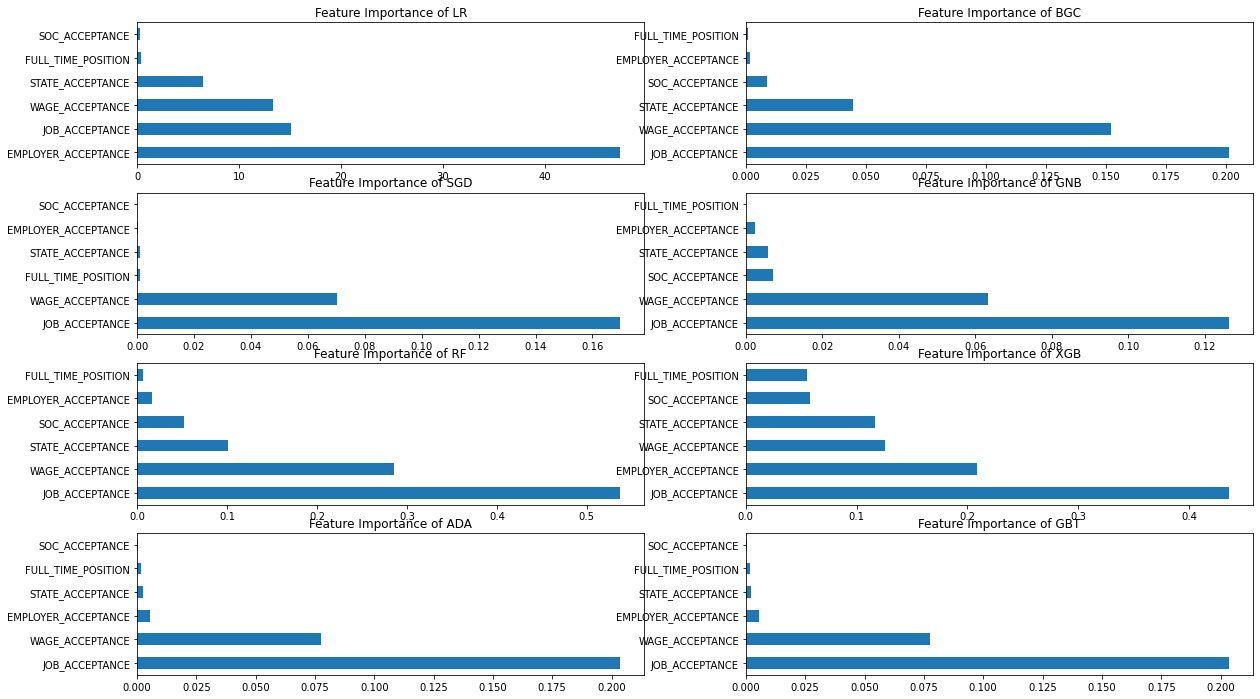

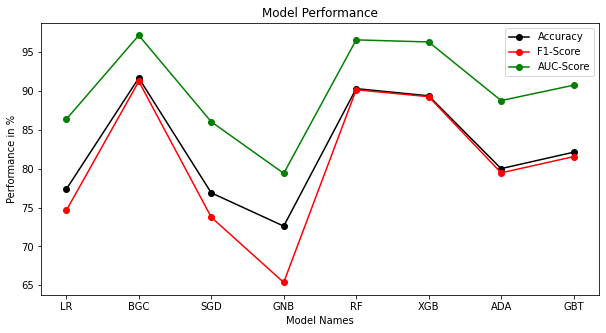

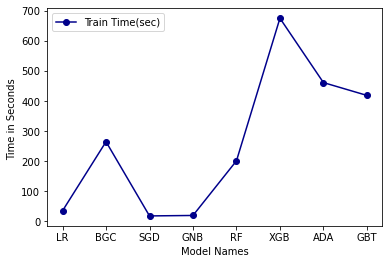

The selected classifiers are: 
1. BGC
2. RF
3. XGB
4. GBT

Phase 3 Started
The final model is ready and has been evaluated the results are as following:
Accuracy : 0.9079581106503891
F1 Score : 0.9058663345497406
AUC Score:  0.9079480992426124
Compilation successful!


In [53]:
hybrid_model_formation(LogisticRegression(), BaggingClassifier( max_samples=0.5, max_features=0.5, n_estimators = 15), SGDClassifier(loss="modified_huber", penalty = "l2"), 
                      GaussianNB(), RandomForestClassifier(n_estimators=25, max_depth = 26), 
                       XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=20,  min_child_weight=1, n_estimators=35, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=0.8, use_label_encoder=False, disable_default_eval_metric=1),AdaBoostClassifier(),GradientBoostingClassifier(n_estimators=25, learning_rate = 0.5), X, Y, list(df.columns))